# OLS Multiple Regression with an Abalone Dataset
Dawud Ujamaa

November 17, 2024

This notebook is prepared for competing in the "Regression with Abalone Dataset (late submission)" on Kaggle.com (https://www.kaggle.com/competitions/playground-series-s4e4). Two models are built and interpreted and regression assumptions are investigated. Output from the better performing model is submitted for evaluation.

## EDA and Preprocessing

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm 
from statsmodels.formula.api import ols 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# import training data
AbaloneTrain = pd.read_csv(r'./train.csv',index_col=0)
AbaloneTrain

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


In [2]:
# rename variables to not include blank spaces
AbaloneTrain.rename(columns={"Whole weight":"Whole_weight","Whole weight.1":"Whole_weight1",
                            "Whole weight.2":"Whole_weight2","Shell weight":"Shell_weight"},inplace=True)

AbaloneTrain.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Whole_weight1',
       'Whole_weight2', 'Shell_weight', 'Rings'],
      dtype='object')

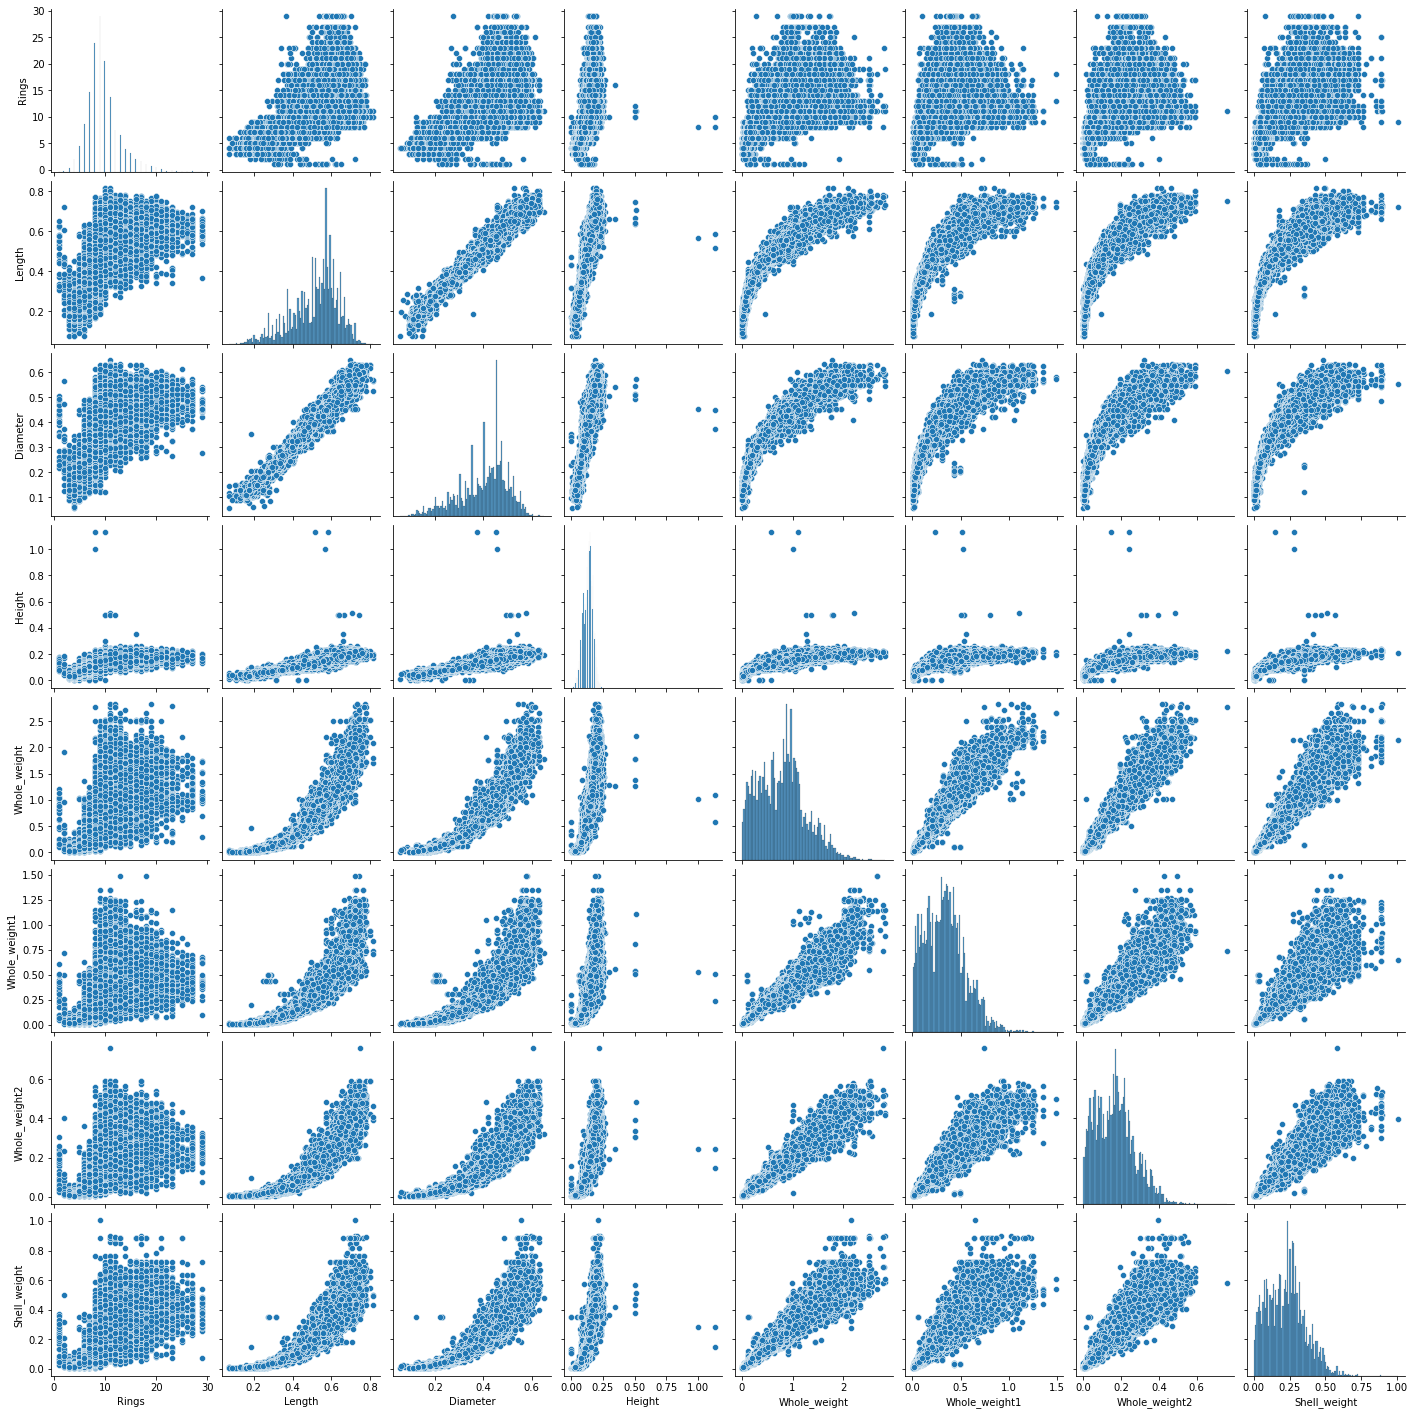

In [3]:
# generate pairs plot to check distribution of variables and 
# assess linear relationship between independent variables and the dependent variable 

sns.pairplot(AbaloneTrain[['Rings','Length','Diameter','Height','Whole_weight',
                           'Whole_weight1','Whole_weight2','Shell_weight']])
plt.show()

In [4]:
# look at correlation between variables
correlation_matrix = AbaloneTrain.corr()
print(correlation_matrix)

                 Length  Diameter    Height  Whole_weight  Whole_weight1  \
Length         1.000000  0.989732  0.916094      0.931449       0.909609   
Diameter       0.989732  1.000000  0.919618      0.933848       0.908466   
Height         0.916094  0.919618  1.000000      0.902344       0.861769   
Whole_weight   0.931449  0.933848  0.902344      1.000000       0.971249   
Whole_weight1  0.909609  0.908466  0.861769      0.971249       1.000000   
Whole_weight2  0.913134  0.914668  0.886132      0.974319       0.949227   
Shell_weight   0.911073  0.917871  0.904019      0.964201       0.911800   
Rings          0.623786  0.636832  0.665772      0.617274       0.515067   

               Whole_weight2  Shell_weight     Rings  
Length              0.913134      0.911073  0.623786  
Diameter            0.914668      0.917871  0.636832  
Height              0.886132      0.904019  0.665772  
Whole_weight        0.974319      0.964201  0.617274  
Whole_weight1       0.949227      0.9118

In [5]:
# check for missing values
missing_values = AbaloneTrain.isnull().sum()
print(missing_values)

Sex              0
Length           0
Diameter         0
Height           0
Whole_weight     0
Whole_weight1    0
Whole_weight2    0
Shell_weight     0
Rings            0
dtype: int64


In [6]:
# check distribution of qualitative Sex variable
AbaloneTrain.Sex.value_counts(dropna=False)

I    33093
M    31027
F    26495
Name: Sex, dtype: int64

In [7]:
# Generate descriptive statistics
AbaloneTrain.describe()

,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


### Conclusions from EDA
* The distribution of the variables shows skewness, so data transformation is needed. 
* Descriptives statistics show that variance is proportional to the mean, so the square root transformation will be used.
* Dummy variables will be created for the qualitative Sex variable
* All the independent variables are highly correlated with each other, so multicollinearity may exist.
* The first model will include all of the variables
* The second model will only include Shell_weight since it has the highest correlation with Rings, and the Sex dummy variables.

## Feature Engineering
Create new features which apply the square root transformation to the independent variables. Add constant 1 to square root transformation to account for features with a minimum value of zero. Create dummy variables for qualitative Sex feature.

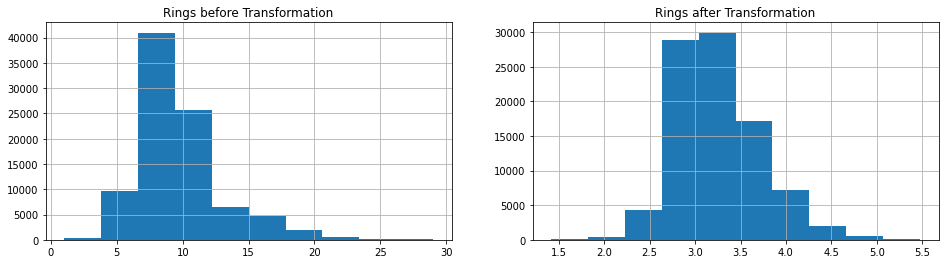

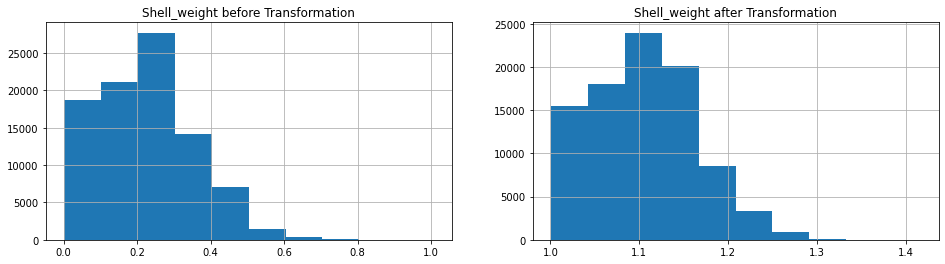

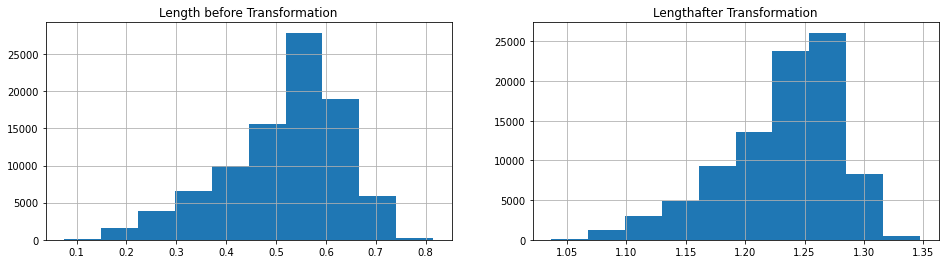

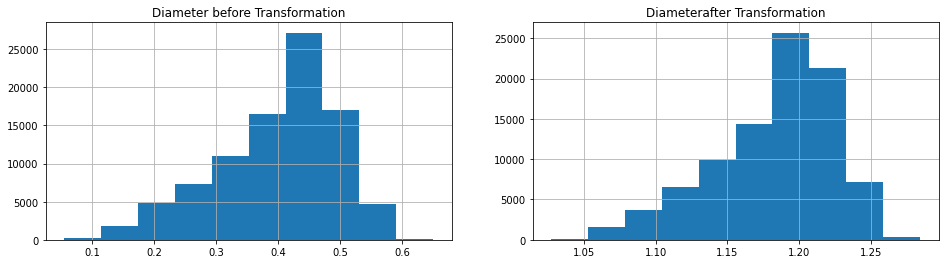

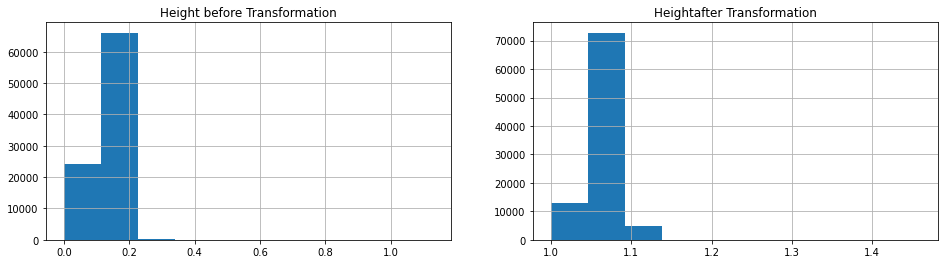

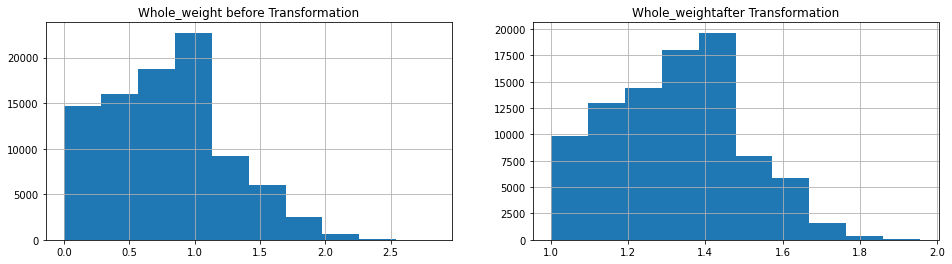

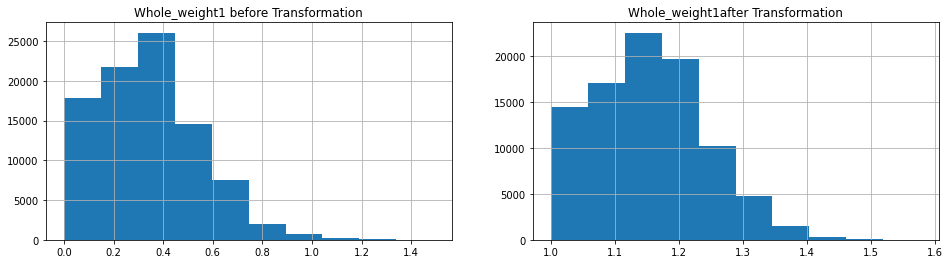

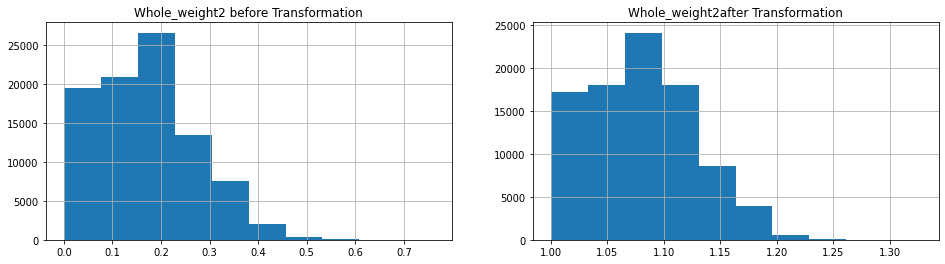

In [8]:
# Create new square root transformed features
AbaloneTrain['Length_Trans'] = np.sqrt(AbaloneTrain['Length']+1)
AbaloneTrain['Diameter_Trans'] = np.sqrt(AbaloneTrain['Diameter']+1)
AbaloneTrain['Height_Trans'] = np.sqrt(AbaloneTrain['Height']+1)
AbaloneTrain['Whole_weight_Trans'] = np.sqrt(AbaloneTrain['Whole_weight']+1)
AbaloneTrain['Whole_weight1_Trans'] = np.sqrt(AbaloneTrain['Whole_weight1']+1)
AbaloneTrain['Whole_weight2_Trans'] = np.sqrt(AbaloneTrain['Whole_weight2']+1)
AbaloneTrain['Shell_weight_Trans'] = np.sqrt(AbaloneTrain['Shell_weight']+1)
AbaloneTrain['Rings_Trans'] = np.sqrt(AbaloneTrain['Rings']+1)

# check distribution after transformation
fig1 = plt.figure(figsize=(16,4))

ax1 = fig1.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Rings'].hist()
ax1.set_title('Rings before Transformation')

ax2 = fig1.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Rings_Trans'].hist()
ax2.set_title('Rings after Transformation');

fig2 = plt.figure(figsize=(16,4))

ax1 = fig2.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Shell_weight'].hist()
ax1.set_title('Shell_weight before Transformation')

ax2 = fig2.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Shell_weight_Trans'].hist()
ax2.set_title('Shell_weight after Transformation')

fig3 = plt.figure(figsize=(16,4))

ax1 = fig3.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Length'].hist()
ax1.set_title('Length before Transformation')

ax2 = fig3.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Length_Trans'].hist()
ax2.set_title('Lengthafter Transformation')
fig4 = plt.figure(figsize=(16,4))

ax1 = fig4.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Diameter'].hist()
ax1.set_title('Diameter before Transformation')

ax2 = fig4.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Diameter_Trans'].hist()
ax2.set_title('Diameterafter Transformation')
fig5 = plt.figure(figsize=(16,4))

ax1 = fig5.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Height'].hist()
ax1.set_title('Height before Transformation')

ax2 = fig5.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Height_Trans'].hist()
ax2.set_title('Heightafter Transformation')
fig6 = plt.figure(figsize=(16,4))

ax1 = fig6.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Whole_weight'].hist()
ax1.set_title('Whole_weight before Transformation')

ax2 = fig6.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Whole_weight_Trans'].hist()
ax2.set_title('Whole_weightafter Transformation')
fig7 = plt.figure(figsize=(16,4))

ax1 = fig7.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Whole_weight1'].hist()
ax1.set_title('Whole_weight1 before Transformation')

ax2 = fig7.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Whole_weight1_Trans'].hist()
ax2.set_title('Whole_weight1after Transformation')
fig8 = plt.figure(figsize=(16,4))

ax1 = fig8.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
AbaloneTrain['Whole_weight2'].hist()
ax1.set_title('Whole_weight2 before Transformation')

ax2 = fig8.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
AbaloneTrain['Whole_weight2_Trans'].hist()
ax2.set_title('Whole_weight2after Transformation');


In [9]:
# Generate dummy variables for sex
AbaloneTrain = pd.get_dummies(AbaloneTrain,columns=['Sex'])
AbaloneTrain

,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Rings,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Rings_Trans,Sex_F,Sex_I,Sex_M
id,,,,,,,,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1.244990,1.195826,1.072381,1.330977,1.152606,1.070747,1.113553,3.464102,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1.276715,1.220656,1.070047,1.459452,1.207477,1.129823,1.148913,3.464102,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,1.077033,1.053565,1.012423,1.010445,1.002746,1.001499,1.002497,2.645751,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,1.262933,1.214496,1.072381,1.383655,1.172817,1.097953,1.118034,3.316625,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,1.246996,1.193734,1.063015,1.334916,1.170256,1.077033,1.094303,3.162278,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,1.155422,1.111306,1.036822,1.076336,1.033683,1.018332,1.022252,2.645751,0,0,1
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,1.246996,1.193734,1.072381,1.370766,1.177497,1.086968,1.113553,3.162278,0,0,1
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,1.197915,1.153256,1.046422,1.149565,1.072847,1.038509,1.039952,2.645751,0,1,0


## Model 1 - include all variables

In [10]:
# Fit OLS multiple regression model using all variables
y = AbaloneTrain['Rings_Trans'] 
x = AbaloneTrain[['Length_Trans','Diameter_Trans','Height_Trans','Whole_weight_Trans',
                       'Whole_weight1_Trans','Whole_weight2_Trans','Shell_weight_Trans','Sex_F','Sex_M']]

# add constant for intercept
x = sm.add_constant(x)

#fit linear regression model
model1 = sm.OLS(y, x).fit()

#view model summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            Rings_Trans   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 1.860e+04
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:52:50   Log-Likelihood:                -12129.
No. Observations:               90615   AIC:                         2.428e+04
Df Residuals:                   90605   BIC:                         2.437e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -7.0973    

In [11]:
# evaluate Model1
Compare = AbaloneTrain[['Rings_Trans','Rings']]
y_pred = model1.predict(x) 
Compare['Rings_Trans_pred'] = y_pred
# use back-transfomration to get predicted rings
Compare['Rings_pred'] = round(Compare['Rings_Trans_pred'].pow(2)-1)
Compare

,Rings_Trans,Rings,Rings_Trans_pred,Rings_pred
id,,,,
0,3.464102,11,3.448320,11.0
1,3.464102,11,3.492891,11.0
2,2.645751,6,2.311392,4.0
3,3.316625,10,3.440434,11.0
4,3.162278,9,3.052699,8.0
...,...,...,...,...
90610,2.645751,6,2.759833,7.0
90611,3.162278,9,3.331022,10.0
90612,2.645751,6,2.810526,7.0


In [12]:
# define function to calculate ME, MPE, MAPE, MAE, MSE, RMSLE
from sklearn.metrics import mean_absolute_error as MAE 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_percentage_error as MAPE 
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def myf(y,yhat): 
    ME=np.round(np.mean(y-yhat),3)
    MPE=np.round(np.mean((y-yhat)/y),3) 
    myMAE=np.round(MAE(y,yhat),3) 
    myMSE=np.round(MSE(y,yhat),3) 
    myMAPE=np.round(MAPE(y,yhat),3) 
    myRMSLE=np.round(rmsle(y,yhat),3) 
    print("\n","ME:", np.round(ME,3),"\n","MPE:",MPE,"\n", "MAE:", myMAE,
          "\n", "MSE:", myMSE,"\n","MAPE:",myMAPE,"\n","RMSLE:",myRMSLE) 
    
myf(Compare['Rings'], Compare['Rings_pred']) 


 ME: 0.075 
 MPE: -0.027 
 MAE: 1.329 
 MSE: 4.053 
 MAPE: 0.133 
 RMSLE: 0.165


### Assess residuals of model1 to investigate assumptions

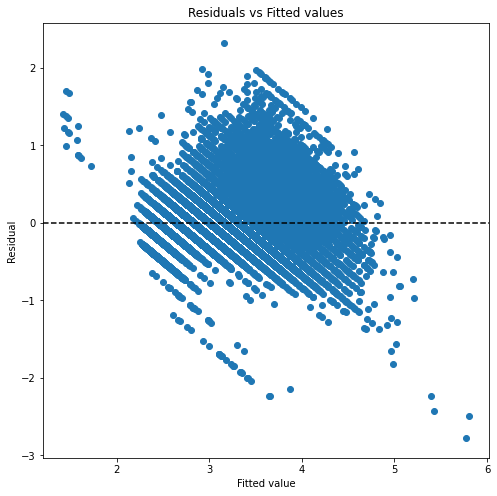

In [13]:
# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(model1.fittedvalues , model1.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

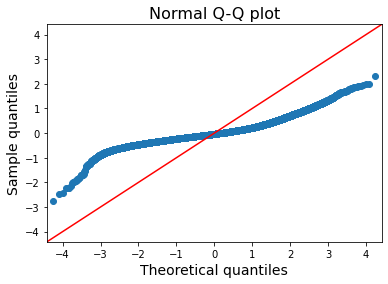

In [14]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(model1.resid)
p = sm.qqplot(resid, line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

16384

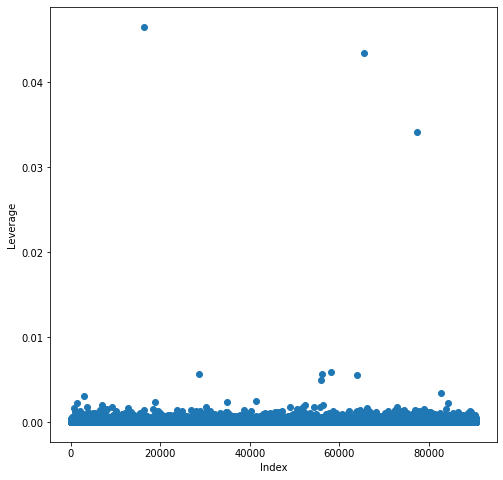

In [15]:
# Calculate Leverage statistics to identify high leverage observations

infl = model1.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(x.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

In [16]:
# calculate VIF to assess multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif)

     VIF Factor             features
0  28270.966916                const
1     53.044641         Length_Trans
2     57.285535       Diameter_Trans
3      8.426983         Height_Trans
4     87.004110   Whole_weight_Trans
5     23.067588  Whole_weight1_Trans
6     20.840807  Whole_weight2_Trans
7     19.485551   Shell_weight_Trans
8      2.148017                Sex_F
9      2.035056                Sex_M


## Model2 - regression model with only Shell_weight and sex dummy variables
The first model used variables with high multicollinearity. The second model will only use the predictors Shell_weight, which had the higest correlation with Rings, and the dummy variables for Sex.

In [17]:
# Fit second OLS multiple regression model
y = AbaloneTrain['Rings_Trans'] 
x = AbaloneTrain[['Shell_weight_Trans','Sex_F','Sex_M']]

# add constant for intercept
x = sm.add_constant(x)

#fit linear regression model
model2 = sm.OLS(y, x).fit()

#view model summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            Rings_Trans   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 3.516e+04
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:52:54   Log-Likelihood:                -24557.
No. Observations:               90615   AIC:                         4.912e+04
Df Residuals:                   90611   BIC:                         4.916e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.5530      0

In [18]:
# evaluate Model2
Compare = AbaloneTrain[['Rings_Trans','Rings']]
y_pred = model2.predict(x) 
Compare['Rings_Trans_pred'] = y_pred
# use back-transfomration to get predicted rings
Compare['Rings_pred'] = round(Compare['Rings_Trans_pred'].pow(2)-1)
myf(Compare['Rings'], Compare['Rings_pred']) 


 ME: 0.107 
 MPE: -0.034 
 MAE: 1.539 
 MSE: 5.284 
 MAPE: 0.154 
 RMSLE: 0.187


### Assess residuals of model2 to investigate assumptions

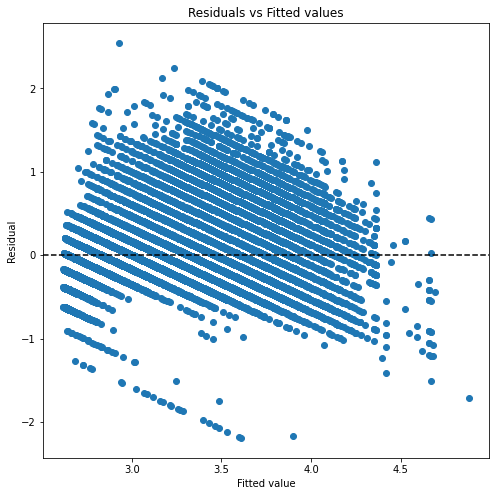

In [19]:
# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(model2.fittedvalues , model2.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

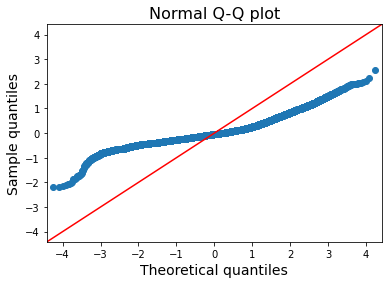

In [20]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(model2.resid)
p = sm.qqplot(resid, line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

72784

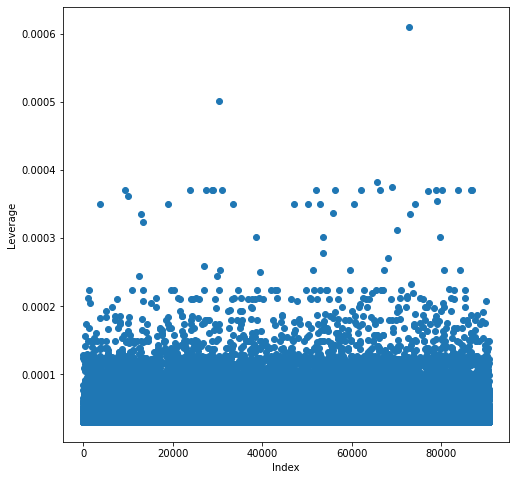

In [21]:
# Calculate Leverage statistics to identify high leverage observations
infl = model2.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(x.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

In [22]:
# calculate VIF to assess multicollinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif)

   VIF Factor            features
0  582.448017               const
1    1.770776  Shell_weight_Trans
2    2.045052               Sex_F
3    1.937324               Sex_M


## Results of comparing both models
The graphs of the residuals of both models to investigate assumptions reveal the same facts about both models:
* The graphs of the "Residuals vs Fitted values" indicates homoscedasticity and that the residuals are independent
* However, the graphs of the "Residuals vs Fitted values" indicates the existence of outlier and that the constant variance assumption is violated.
* The graphs of the Normal Q-Q plot indicate that the Normality of residuals assumption is violated
* The graphs of the Leverage statistics for each observation indicates the evidence of high leverage observations. 

Model1 has a higher Adj. R-squared and lower values for ME, MPE, MAPE, MAE, MSE, RMSLE than Model2. However, Model1 may be overfit since it uses all the variables, and also has high multicollinearity. So, Model2 is selected as the preferred model.

## Generate predictions on the test data

In [23]:
# import test data
AbaloneTest = pd.read_csv(r'./test.csv')

# rename variables
AbaloneTest.rename(columns={"Whole weight":"Whole_weight","Whole weight.1":"Whole_weight1",
                            "Whole weight.2":"Whole_weight2","Shell weight":"Shell_weight"},inplace=True)
AbaloneTest

,id,Sex,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050
...,...,...,...,...,...,...,...,...,...
60406,151021,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500
60407,151022,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050
60408,151023,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650
60409,151024,F,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350


In [24]:
# transform test data and Generate dummy variables for sex
AbaloneTest['Length_Trans'] = np.sqrt(AbaloneTest['Length']+1)
AbaloneTest['Diameter_Trans'] = np.sqrt(AbaloneTest['Diameter']+1)
AbaloneTest['Height_Trans'] = np.sqrt(AbaloneTest['Height']+1)
AbaloneTest['Whole_weight_Trans'] = np.sqrt(AbaloneTest['Whole_weight']+1)
AbaloneTest['Whole_weight1_Trans'] = np.sqrt(AbaloneTest['Whole_weight1']+1)
AbaloneTest['Whole_weight2_Trans'] = np.sqrt(AbaloneTest['Whole_weight2']+1)
AbaloneTest['Shell_weight_Trans'] = np.sqrt(AbaloneTest['Shell_weight']+1)

AbaloneTest = pd.get_dummies(AbaloneTest,columns=['Sex'])
AbaloneTest

,id,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Sex_F,Sex_I,Sex_M
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1.282576,1.214496,1.074709,1.495995,1.272203,1.145644,1.140395,0,0,1
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1.256981,1.208305,1.077033,1.408190,1.215936,1.104310,1.129159,0,0,1
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1.249000,1.191638,1.067708,1.356282,1.162970,1.088347,1.113777,0,0,1
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1.252996,1.220656,1.070047,1.368941,1.162970,1.089266,1.111306,0,0,1
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1.189538,1.151086,1.053565,1.165333,1.075872,1.032957,1.051190,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,1.159741,1.122497,1.041633,1.085127,1.036098,1.013163,1.024695,0,1,0
60407,151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.234909,1.187434,1.070047,1.358124,1.178346,1.080278,1.097725,1,0,0
60408,151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,1.260952,1.200000,1.074709,1.456709,1.180254,1.095445,1.124722,0,1,0
60409,151024,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1.288410,1.234909,1.090871,1.579082,1.260357,1.165118,1.197915,1,0,0


In [25]:
# Model1 Predict on the test data
x_test1 = AbaloneTest[['Length_Trans','Diameter_Trans','Height_Trans','Whole_weight_Trans',
                       'Whole_weight1_Trans','Whole_weight2_Trans','Shell_weight_Trans','Sex_F','Sex_M']]

# add constant for intercept
x_test1 = sm.add_constant(x_test1)

#fit linear regression model
y_pred1 = model1.predict(x_test1)

# use back-transfomration to get predicted rings
Output1 = AbaloneTest
Output1['Rings'] = round(y_pred1.pow(2) - 1)
Output1

,id,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Sex_F,Sex_I,Sex_M,Rings
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1.282576,1.214496,1.074709,1.495995,1.272203,1.145644,1.140395,0,0,1,9.0
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1.256981,1.208305,1.077033,1.408190,1.215936,1.104310,1.129159,0,0,1,10.0
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1.249000,1.191638,1.067708,1.356282,1.162970,1.088347,1.113777,0,0,1,10.0
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1.252996,1.220656,1.070047,1.368941,1.162970,1.089266,1.111306,0,0,1,11.0
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1.189538,1.151086,1.053565,1.165333,1.075872,1.032957,1.051190,0,1,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,1.159741,1.122497,1.041633,1.085127,1.036098,1.013163,1.024695,0,1,0,7.0
60407,151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.234909,1.187434,1.070047,1.358124,1.178346,1.080278,1.097725,1,0,0,9.0
60408,151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,1.260952,1.200000,1.074709,1.456709,1.180254,1.095445,1.124722,0,1,0,11.0
60409,151024,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1.288410,1.234909,1.090871,1.579082,1.260357,1.165118,1.197915,1,0,0,13.0


In [26]:
# generate output for submission for Model1
Submission1 = Output1[['id','Rings']]
Submission1.to_csv(r'AbaloneRegressionSubmission1.csv', index = False)

In [27]:
# Model2 Predict on the test data
x_test2 = AbaloneTest[['Shell_weight_Trans','Sex_F','Sex_M']]

# add constant for intercept
x_test2 = sm.add_constant(x_test2)

#fit linear regression model
y_pred2 = model2.predict(x_test2)

# use back-transfomration to get predicted rings
Output2 = AbaloneTest
Output2['Rings'] = round(y_pred2.pow(2) - 1)
Output2

,id,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Sex_F,Sex_I,Sex_M,Rings
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1.282576,1.214496,1.074709,1.495995,1.272203,1.145644,1.140395,0,0,1,11.0
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1.256981,1.208305,1.077033,1.408190,1.215936,1.104310,1.129159,0,0,1,11.0
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1.249000,1.191638,1.067708,1.356282,1.162970,1.088347,1.113777,0,0,1,10.0
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1.252996,1.220656,1.070047,1.368941,1.162970,1.089266,1.111306,0,0,1,10.0
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1.189538,1.151086,1.053565,1.165333,1.075872,1.032957,1.051190,0,1,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,1.159741,1.122497,1.041633,1.085127,1.036098,1.013163,1.024695,0,1,0,7.0
60407,151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.234909,1.187434,1.070047,1.358124,1.178346,1.080278,1.097725,1,0,0,10.0
60408,151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,1.260952,1.200000,1.074709,1.456709,1.180254,1.095445,1.124722,0,1,0,10.0
60409,151024,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1.288410,1.234909,1.090871,1.579082,1.260357,1.165118,1.197915,1,0,0,13.0


In [28]:
# generate output for submission for Model2
Submission2 = Output2[['id','Rings']]
Submission2.to_csv(r'AbaloneRegressionSubmission2.csv', index = False)